# Boosting ground states preparation interfacing VQEs and DBQAs

In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt

import cma

import qibo
from qibo import hamiltonians, optimizers, gates, Circuit

from qibo.models.dbi.double_bracket import (
    DoubleBracketIteration,
    DoubleBracketGeneratorType,
)

from boostvqe import ansatze
from boostvqe.utils import rotate_h_with_vqe
from boostvqe.models.dbi.double_bracket_evolution_oracles import (
    XXZ_EvolutionOracle,
    FrameShiftedEvolutionOracle,
    IsingNNEvolutionOracle
)

from boostvqe.models.dbi.group_commutator_iteration_transpiler import (
    DoubleBracketRotationType,
    GroupCommutatorIterationWithEvolutionOracles,
)

E0000 00:00:1733303596.062235   42717 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733303596.068023   42717 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from importlib import reload
reload(ansatze)

<module 'boostvqe.ansatze' from '/home/matteo/Documents/PhD/boostvqe/src/boostvqe/ansatze.py'>

In [3]:
qibo.set_backend("qiboml", platform="tensorflow")
plt.set_loglevel('WARNING') 

[Qibo 0.2.14|INFO|2024-12-04 10:13:24]: Using qiboml (tensorflow) backend on /device:CPU:0
INFO:qibo.config:Using qiboml (tensorflow) backend on /device:CPU:0


#### Some plotting functions

In [4]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    # print the abs value of the components of the matrix
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)

def plot_vqe_states(state, state2=None):
    """
    Plot `state` and `state2` if provided. 
    """
    n = int(np.log2(len(state)))
    bitstrings = [format(i, f"0{n}b") for i in range(2**n)] 
    
    plt.figure(figsize=(12,4))
    for i, amp in enumerate(state):
        if i == 0:
            plt.bar(bitstrings[i], np.abs(amp)**2, color='#C194D8', alpha=0.7, edgecolor="black", label="Ground state")
        else:
            plt.bar(bitstrings[i], np.abs(amp)**2, color='#C194D8', alpha=0.7, edgecolor="black")
    if state2 is not None:     
        for i, amp in enumerate(state2):
            if i == 0:
                plt.bar(bitstrings[i], np.abs(amp)**2, color='black', alpha=1, edgecolor="black", hatch="\\\\", facecolor="none", label="VQE approximation")
            else:
                plt.bar(bitstrings[i], np.abs(amp)**2, color='black', alpha=1, edgecolor="black", hatch="\\\\", facecolor="none")
                
    plt.xticks(ticks=range(len(bitstrings)), labels=bitstrings, rotation=90)
    plt.xlabel("Components")
    plt.ylabel("Probabilities")
    plt.title("State representation")
    plt.legend()
    plt.show()

def plot_loss(loss_history, vqe):
    target_gs_energy = np.min(np.array(np.real(vqe.hamiltonian.eigenvalues())))
    plt.figure(figsize=(6, 6 * 6 / 8))
    plt.plot(loss_history, color="purple", label="Loss history", lw=1.5, alpha=0.7)
    plt.hlines(target_gs_energy, 0, len(loss_history), color="black", label="Target GS energy", lw=1.5, alpha=0.7, ls="--")
    plt.legend()
    plt.show()

#### Problem setup

We consider an Hamming-weight preserving ansatz to approximate the target circuit. It is a good choice to reduce the complexity of the circuit while perfectly fulfilling the problem simmetries.

In [5]:
# Fix the size of the problem
nqubits = 6
nlayers = 3

In [6]:
# Build circuit
# circ0 = ansatze.hdw_efficient(nqubits=nqubits, nlayers=nlayers)
circ0 = ansatze.hw_preserving(nqubits=nqubits, nlayers=nlayers)
circ0.draw()

# We save a copy of the circuit for later
circ = circ0.copy(deep=True)

0:     ─X─RBS─────────────────RBS─RBS─────────RBS─────RBS─────────────────RBS ...
1:     ─X─RBS─────────RBS─────|───|───────RBS─|───────RBS─────────RBS─────|── ...
2:     ─X─────RBS─────RBS─────|───RBS─────|───|───────────RBS─────RBS─────|── ...
3:     ───────RBS─────────RBS─|───────RBS─RBS─|───RBS─────RBS─────────RBS─|── ...
4:     ───────────RBS─────RBS─|───────|───────RBS─|───────────RBS─────RBS─|── ...
5:     ───────────RBS─────────RBS─────RBS─────────RBS─────────RBS─────────RBS ...

0: ... ─RBS─────────RBS─────RBS─────────────────RBS─RBS─────────RBS─────
1: ... ─|───────RBS─|───────RBS─────────RBS─────|───|───────RBS─|───────
2: ... ─RBS─────|───|───────────RBS─────RBS─────|───RBS─────|───|───────
3: ... ─────RBS─RBS─|───RBS─────RBS─────────RBS─|───────RBS─RBS─|───RBS─
4: ... ─────|───────RBS─|───────────RBS─────RBS─|───────|───────RBS─|───
5: ... ─────RBS─────────RBS─────────RBS─────────RBS─────RBS─────────RBS─


In [7]:
# Initial parameters are zeros
default_params = circ.get_parameters()
nparams = len(default_params)
print(f" Default params: {default_params}\n nparams: {nparams}")

 Default params: [(0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,)]
 nparams: 33


In [8]:
# Build input Hamiltonian
h0 = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
ground_state = h0.ground_state()
gs_energy = np.min(np.real(h0.eigenvalues()))

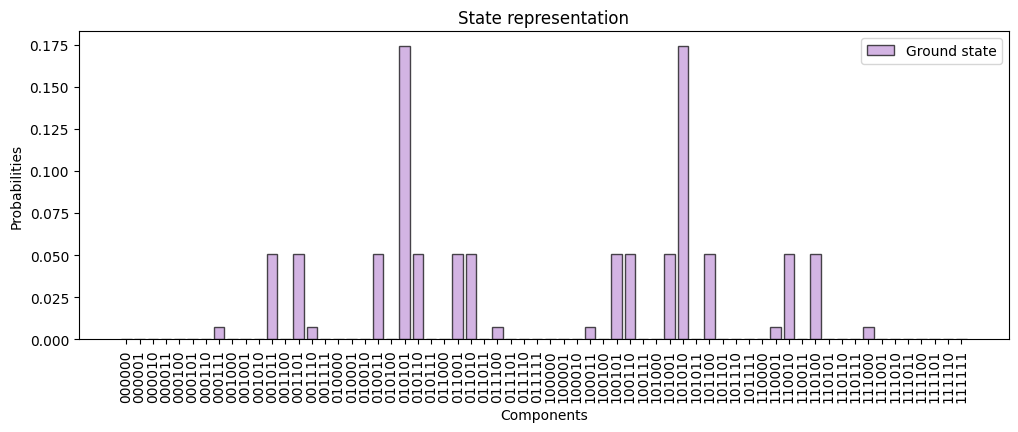

In [9]:
# Plot one (or eventually two) states
plot_vqe_states(ground_state)

In [10]:
# Initialize VQE object
vqe = ansatze.VQE(circuit=circ, hamiltonian=copy.deepcopy(h0))

#### Train the VQE

We now use the Qibo Tensorflow backend to train the VQE with a gradient descent strategy.

In [11]:
# Set initial params
initial_parameters  = np.random.normal(0., 0.5, nparams)

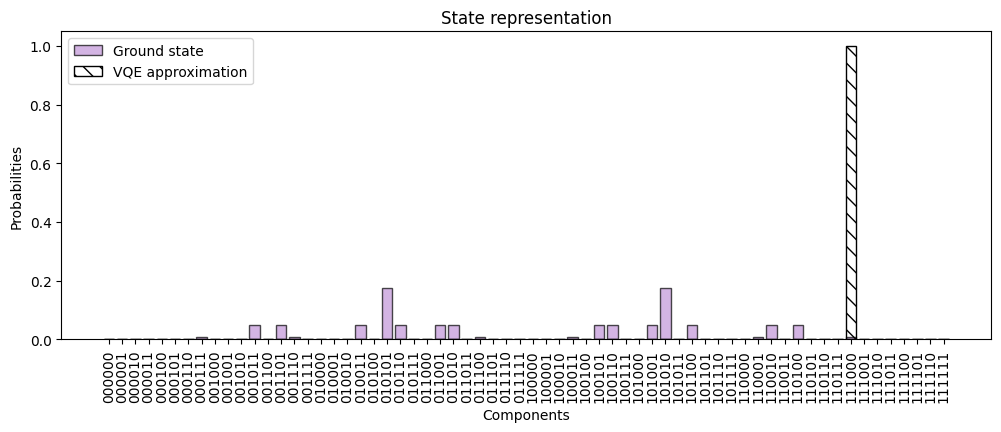

In [12]:
# VQE ground state before setting initial parameters
plot_vqe_states(ground_state, vqe.circuit().state())

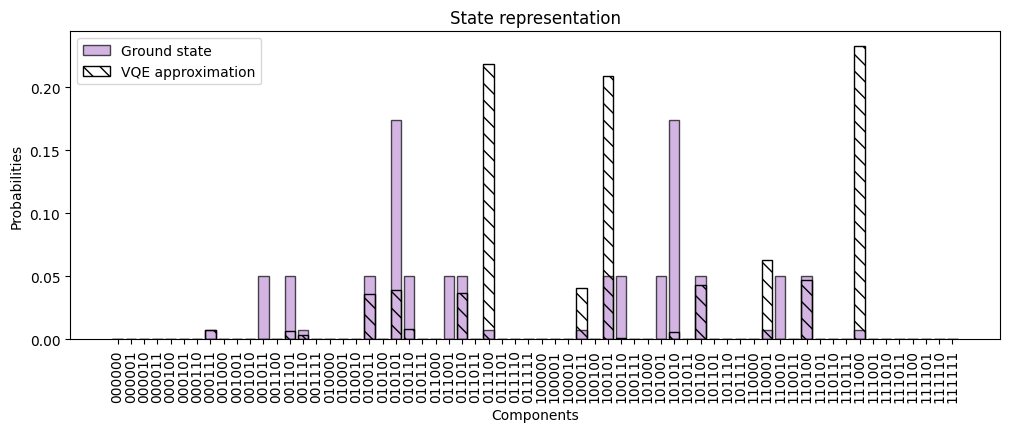

In [13]:
# Set random parameters and re-plot the states
vqe.circuit.set_parameters(initial_parameters)
plot_vqe_states(ground_state, vqe.circuit().state())

##### Defining some callbacks to keep track during optimization

In [18]:
loss_history, params_history = [], []

def tracker_function(
    params, 
    vqe=vqe, 
    loss_history=loss_history,
    params_history=params_history,
):
    """Keep track of loss function and VQE params history during the optimization."""
    vqe.circuit.set_parameters(params)
    loss_history.append(
        vqe.hamiltonian.expectation(
            vqe.circuit().state()
        )
    )
    params_history.append(params)
    print(f"Exec. iteration {len(loss_history)} \t Loss: {loss_history[-1]}")

In [19]:
# Optimization options
optimizer_options = {
    "nepochs" : 100,
    "method": "Adam",
    "nmessage": 1,
    "learning_rate": 0.05,
}

# Fix the random seed
backend = qibo.get_backend().tf.random.set_seed(42)

# Use the vqe.minimize method
opt_results = vqe.minimize(
    initial_parameters, 
    method="sgd", 
    options=optimizer_options,
    callback=tracker_function
)

Exec. iteration 1 	 Loss: -1.0498506565931882
Exec. iteration 2 	 Loss: -2.367119914834552
Exec. iteration 3 	 Loss: -3.162280687794077
Exec. iteration 4 	 Loss: -3.656820832221701
Exec. iteration 5 	 Loss: -3.987051861790752
Exec. iteration 6 	 Loss: -4.219753330154982
Exec. iteration 7 	 Loss: -4.394889954203612
Exec. iteration 8 	 Loss: -4.54114749348168
Exec. iteration 9 	 Loss: -4.679173109494979
Exec. iteration 10 	 Loss: -4.822256249158036
Exec. iteration 11 	 Loss: -4.9775763161739475
Exec. iteration 12 	 Loss: -5.147921130451096
Exec. iteration 13 	 Loss: -5.333305226261867
Exec. iteration 14 	 Loss: -5.532161934608809
Exec. iteration 15 	 Loss: -5.742060397537629
Exec. iteration 16 	 Loss: -5.960052025305931
Exec. iteration 17 	 Loss: -6.182807628415448
Exec. iteration 18 	 Loss: -6.406705117773864
Exec. iteration 19 	 Loss: -6.627963655190217
Exec. iteration 20 	 Loss: -6.84283820934075
Exec. iteration 21 	 Loss: -7.047843733503014
Exec. iteration 22 	 Loss: -7.2399750063688

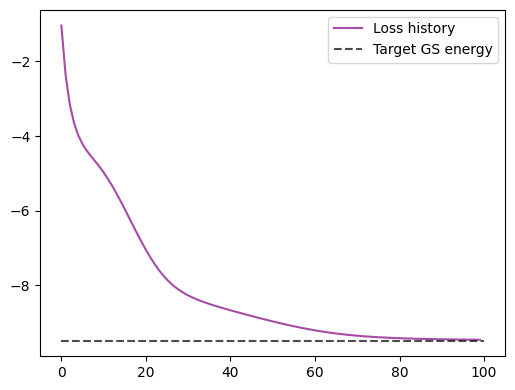

In [20]:
plot_loss(loss_history, vqe)

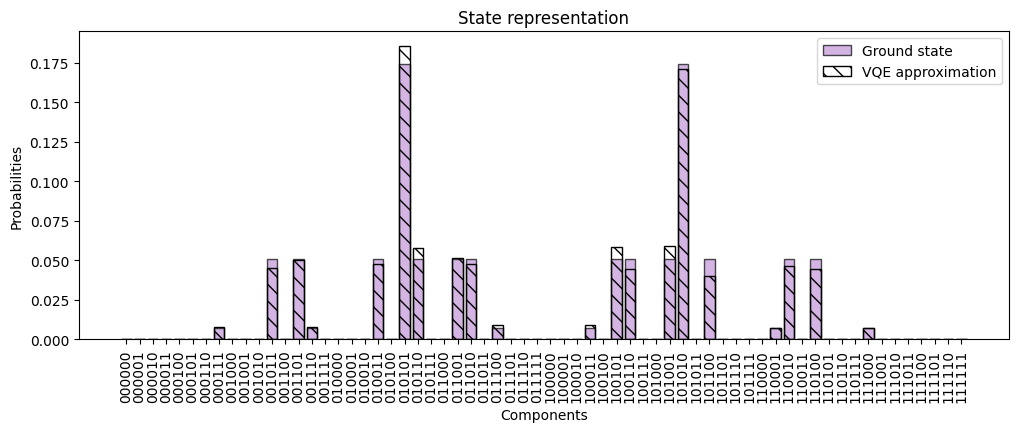

In [22]:
# Plot the VQE approximation together with the target
plot_vqe_states(ground_state, vqe.circuit().state())

#### Apply DBQA after warm start

As explained in the talk, we aim to apply a DBI to a target input of shape:
$$ \hat{A}_0 = \hat{U}^{\dagger} \hat{H}_0 \hat{U}.$$

In [42]:
# We interface the VQE with the DBQA by setting A  = (U^dagger H U)
vqe_unitary = np.matrix(vqe.circuit.unitary())
rotated_h_matrix = vqe_unitary.getH() @ h0.matrix @ vqe_unitary

In [43]:
# Transform it into a Qibo hamiltonian
rotated_h = hamiltonians.Hamiltonian(nqubits=nqubits, matrix=rotated_h_matrix)

Now we can use this new input to build a DBI.

In [44]:
# Construct the DBI
dbi = DoubleBracketIteration(
    hamiltonian=rotated_h,
    mode=DoubleBracketGeneratorType.single_commutator,
)

In [45]:
# Apply three steps of DBI
operators, energies = [], []
for _ in range(3):
    dbi_op = dbi(step=0.01, d=dbi.diagonal_h_matrix)
    zero_state = np.transpose([dbi.h.backend.zero_state(dbi.h.nqubits)])
    energies.append(dbi.h.expectation(zero_state))
    # Collect DBI operators
    operators.append(dbi_op)

In [46]:
# Collect DBI operators
dbi_operators = [
    h0.backend.cast(np.matrix(h0.backend.to_numpy(operator)))
    for operator in operators
]

In [47]:
# Print energies after each DBI step
energies

[<tf.Tensor: shape=(), dtype=float64, numpy=-9.46830761388747>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-9.470616821566098>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-9.47135056224725>]

In [48]:
# Constructing a circuit containing initial VQE and DBI operators 
old_circ_matrix = circ.unitary()

circ = Circuit(nqubits)
for gate in reversed([old_circ_matrix] + operators):
    circ.add(gates.Unitary(gate, *range(nqubits), trainable=False))

In [49]:
circ.draw()

0: ─U─U─U─U─
1: ─U─U─U─U─
2: ─U─U─U─U─
3: ─U─U─U─U─
4: ─U─U─U─U─
5: ─U─U─U─U─


In [50]:
# Construct a VQE out of this circuit
vqe1 = ansatze.VQE(hamiltonian=copy.deepcopy(h0), circuit=circ)

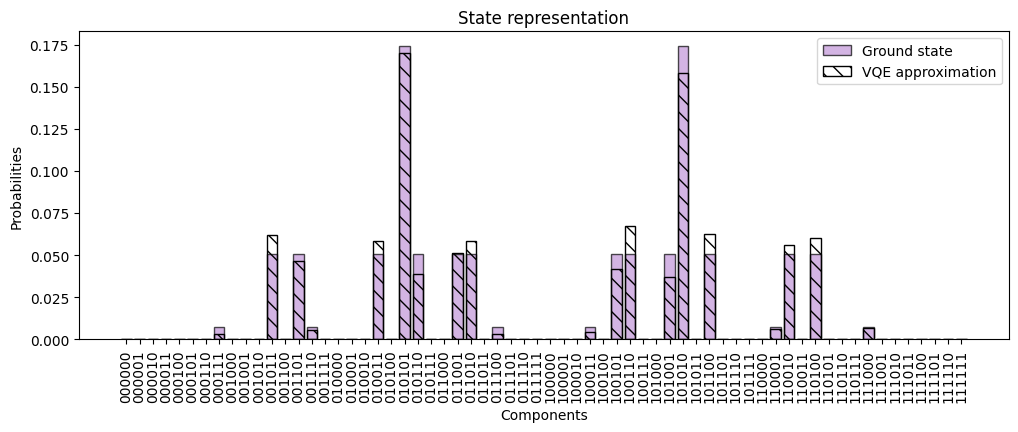

In [51]:
# Plotting Boosted VQE state
plot_vqe_states(ground_state, vqe1.circuit().state())

#### Apply GCI (you are allowed to disconnect here XD)

Now I will show you how to do the same but using a GCI, namely a synthetized and compiled version of the DBI.
I will not delve deep inside the compilation itelf but show you the tools that can be extracted from `boostvqe` to explore it.

In [53]:
qibo.set_backend("numpy")

[Qibo 0.2.14|INFO|2024-12-04 10:31:04]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In [54]:
def loss_function_gci(
    params, 
    gci,
    ham,
    dbr_mode,
):
    """Execute a copy of GCI and compute expval."""
    gci_copy = copy.deepcopy(gci)
    # collect parameters

    eo_d_type = IsingNNEvolutionOracle
    eo_d = eo_d_type.load(params[1:])
    
    gci_copy(step_duration=params[0], diagonal_association=eo_d, mode_dbr=dbr_mode)
    gci_circuit = gci_copy.get_composed_circuit()

    return ham.expectation(gci_circuit().state())

def optimize_GCI(
    gci, 
    params, 
    ham,
    dbr_mode,
    s_bounds=(1e-4, 1.), 
    b_bounds=(0., 9.),
):
    """
    Optimize all hyper-parameters of the GCI, namely the stepsize and the alphas and betas
    which parametrize the D operator.
    """

    lower_bounds = s_bounds[0] + b_bounds[0] * (len(params) - 1)
    upper_bounds = s_bounds[1] + b_bounds[1] * (len(params) - 1)
    bounds = [lower_bounds, upper_bounds]
    result = cma.fmin(
        loss_function_gci,
        sigma0=0.5,
        x0=params,
        args=(gci, ham, dbr_mode),
        options={"bounds": bounds, "maxiter": 100},
    )[0]
    return result

In [55]:
# XXZ ham
base_oracle = XXZ_EvolutionOracle.from_nqubits(
    nqubits=nqubits, delta=0.5, steps=3, order=2
)

oracle = FrameShiftedEvolutionOracle.from_evolution_oracle(
    before_circuit=vqe.circuit.invert(),
    after_circuit=vqe.circuit,
    base_evolution_oracle=base_oracle,
)

dbr_type = DoubleBracketRotationType.group_commutator_third_order_reduced

gci = GroupCommutatorIterationWithEvolutionOracles(
    input_hamiltonian_evolution_oracle=oracle,
    double_bracket_rotation_type=dbr_type,
)

In [56]:
gci_circuit = gci.get_composed_circuit()
print(gci_circuit.summary())

Circuit depth = 16
Total number of gates = 36
Number of qubits = 6
Most common gates:
rbs: 33
x: 3


In [57]:
eo_d_type = IsingNNEvolutionOracle

params = [0.01]
params.extend(np.random.uniform(0., 6., nqubits * 2))

eo_d = eo_d_type.load(params[1:])

In [58]:
h0 = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)

In [59]:
gci(step_duration=0.05, diagonal_association=eo_d, mode_dbr=dbr_type)

In [60]:
opt_results = optimize_GCI(
    gci=gci,
    params=params,
    ham=h0,
    dbr_mode=dbr_type,
)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 13 (seed=455011, Wed Dec  4 10:31:43 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 -9.443947138803722e+00 1.0e+00 4.62e-01  5e-01  5e-01 0:03.6
    2     22 -9.455040858265843e+00 1.1e+00 4.31e-01  4e-01  4e-01 0:07.1
    3     33 -9.372305510262802e+00 1.2e+00 4.05e-01  4e-01  4e-01 0:10.6
    4     44 -9.455613322080881e+00 1.2e+00 3.78e-01  3e-01  4e-01 0:14.2
    6     66 -9.443182855089956e+00 1.3e+00 3.62e-01  3e-01  4e-01 0:21.2
    8     88 -9.456413701472126e+00 1.4e+00 3.65e-01  3e-01  4e-01 0:28.1
   10    110 -9.371666553009803e+00 1.6e+00 3.73e-01  3e-01  4e-01 0:35.1
   12    132 -9.457888960734941e+00 1.8e+00 3.61e-01  2e-01  4e-01 0:42.3
   15    165 -9.450098143703560e+00 2.0e+00 3.04e-01  2e-01  3e-01 0:52.8
   18    198 -9.458879639960095e+00 2.1e+00 3.03e-01  2e-01  3e-01 1:03.6
   21    231 -9.447439616068159e+00 2.4e+00 3.04e-01  2e-01  3e-01 1:14.0
   25    275 -9.436836

In [61]:
# Collect best params
step_duration = opt_results[0]
d_params = opt_results[1:]

In [62]:
# Update the EvolutionOracle with those best params
eo_d = eo_d_type.load(d_params)

In [67]:
# Execute an optimized GCI
gci(step_duration=step_duration, diagonal_association=eo_d, mode_dbr=dbr_type)

In [68]:
# Collect the circuit
gci_circuit = gci.get_composed_circuit()

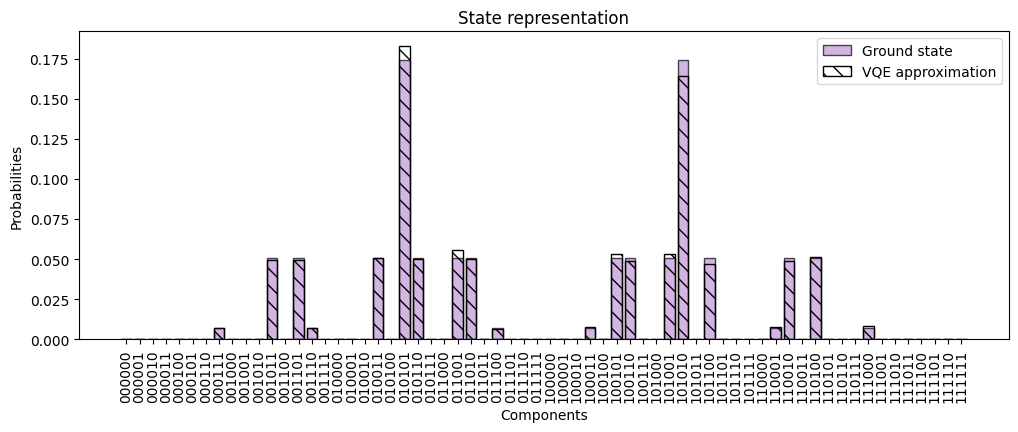

In [69]:
# Plot the GCI state
plot_vqe_states(ground_state, gci_circuit().state())

In [70]:
print(gci_circuit.summary())

Circuit depth = 5007
Total number of gates = 11196
Number of qubits = 6
Most common gates:
rbs: 4125
cx: 2790
rz: 2790
ry: 1116
x: 375
